# Imports and constants

In [1]:
import os 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
import statsmodels.formula.api as smf

/Applications/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
TOP_FOLDER = "data/"
TERRORISM_FILE = TOP_FOLDER + 'short_terrorism.csv'
DOMESTIC_FILE = TOP_FOLDER + 'domestic_security.csv'

As described in the report, our input is two csv files, in the same format as the Wikipedia views from the paper but with a number of tweets per day and per subject instead. On this dataset, we will perform some cleaning, then exploration of the data, and finally an in-depth analysis.

# 1 - Loading

In [3]:
terrorism_raw = pd.read_csv(TERRORISM_FILE, index_col=0)
domestic_raw = pd.read_csv(DOMESTIC_FILE, index_col=0)

In [4]:
print(len(terrorism_raw))
terrorism_raw.head()

29592


,date,tweets,article
0,2012-01-01,7,abu_sayyaf
1,2012-01-02,1,abu_sayyaf
2,2012-01-03,5,abu_sayyaf
3,2012-01-04,22,abu_sayyaf
4,2012-01-05,93,abu_sayyaf


In [5]:
print(len(domestic_raw))
domestic_raw.head()

26304


,date,tweets,article
0,2012-01-01,11,air_marshal
1,2012-01-02,13,air_marshal
2,2012-01-03,9,air_marshal
3,2012-01-04,9,air_marshal
4,2012-01-05,7,air_marshal


Nothing to comment as of yet. We only have the columns that are of use to us, which are the date and keyword as well as the number of tweets for this combination

# 2 -  Cleaning

In [7]:
# We check the types of the columns, as well as the number of keywords and dates
print('Columns types in the terrorism dataset: \n', terrorism_raw.dtypes)
print('Columns types in the domestic security dataset: \n', domestic_raw.dtypes)
print('Number of terrorism keywords: ', terrorism_raw.article.nunique())
print('Number of domestic security keywords: ', domestic_raw.article.nunique())
print('The number of dates in each dataset should be equal: {} and {}'.format(domestic_raw.date.nunique(), terrorism_raw.date.nunique()))

Columns types in the terrorism dataset: 
 date       object
tweets      int64
article    object
dtype: object
Columns types in the domestic security dataset: 
 date       object
tweets      int64
article    object
dtype: object
Number of terrorism keywords:  27
Number of domestic security keywords:  24
The number of dates in each dataset should be equal: 1096 and 1096


In [8]:
# Converting date types from String to datetime
terrorism_raw['date'] = pd.to_datetime(terrorism_raw.date)
domestic_raw['date'] = pd.to_datetime(domestic_raw.date)

In [9]:
# Checking that we do not have any invalid values
print(terrorism_raw.isna().sum())
print(domestic_raw.isna().sum())

date       0
tweets     0
article    0
dtype: int64
date       0
tweets     0
article    0
dtype: int64


In [10]:
# Checking that the dates start and end at the right time
print(terrorism_raw.date.min(), terrorism_raw.date.max())
print(domestic_raw.date.min(), domestic_raw.date.max())

2012-01-01 00:00:00 2014-12-31 00:00:00
2012-01-01 00:00:00 2014-12-31 00:00:00


In [11]:
terrorism_df = terrorism_raw.copy()
domestic_df = domestic_raw.copy()

Now that we know our datasets have no obvious anomalies, and all our data types are coherent, we can start the exploration phase.

# 3 - Exploration

In [13]:
def plot_articles_monthly(df, sample=False):
    """
    For a given dataframe, plots the views per month. Plot a random article is `sample` is 
    `True` and all of them otherwise.
    """
    articles = df.article.unique()
    
    if sample:
        index = np.random.randint(len(articles))
        articles = [articles[index]]
        
    for article in articles:
        monthly = df[df.article == article].groupby(pd.Grouper(key='date', freq='M')).sum()
        plt.figure(figsize=(15,3))
        sns.scatterplot(x='date', y='tweets', data=monthly)
        plt.title(article)
        plt.show()

The first exploratory step is to look at the views per keyword, but since we don't want to plot every day as it would be too many datapoints and be unreadable we will group them by month.

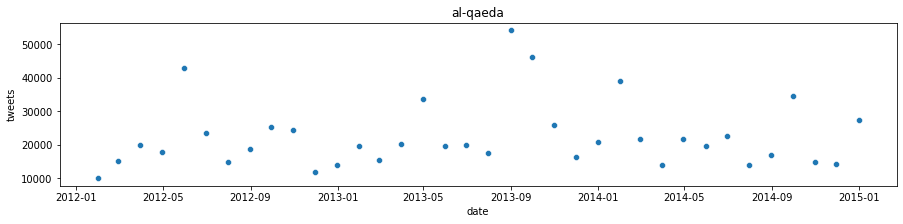

In [19]:
plot_articles_monthly(terrorism_df, sample=True)

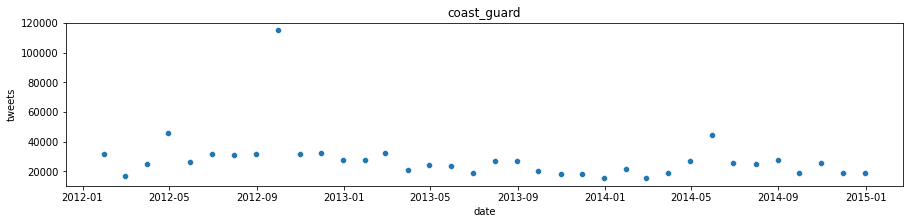

In [20]:
plot_articles_monthly(domestic_df, sample=True)

We observe that for individual articles, the tweet count is quite irregular. Let us look at the global trend by aggregating every keyword.

In [21]:
monthly_terrorism_df = terrorism_df.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()
monthly_domestic_df = domestic_df.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()

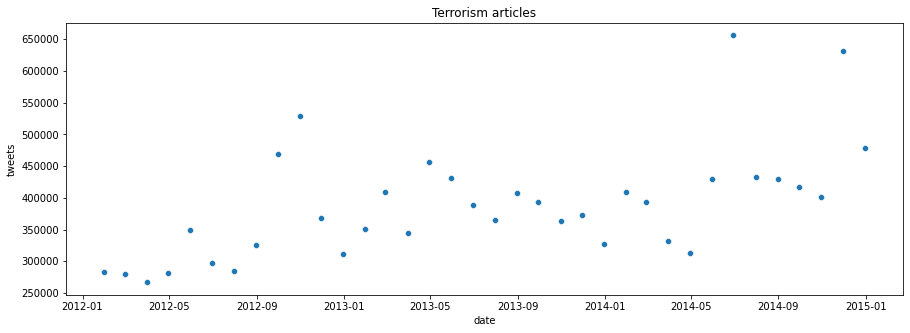

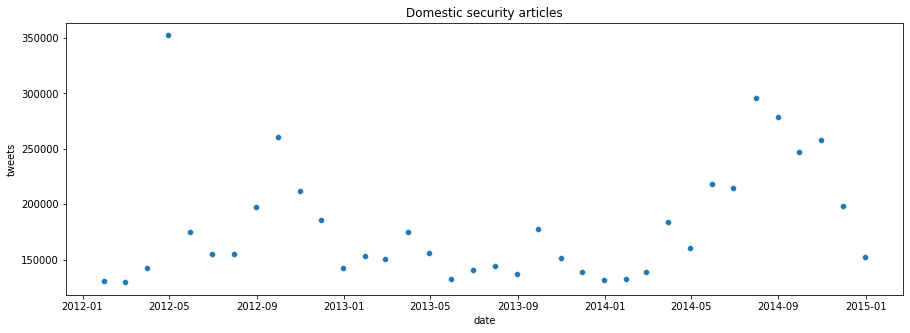

In [28]:
def plot_global_trend(df, title):
    """Plot the number of tweets per day contained in the given dataframe."""
    plt.figure(figsize=(15,5))
    sns.scatterplot(x='date', y='tweets', data=df)
    plt.title(title)

plot_global_trend(monthly_terrorism_df, 'Terrorism articles')
plot_global_trend(monthly_domestic_df, 'Domestic security articles')

Here the data is not as irregular but we still have some peaks at various points in time and not a stable trend. However, we might have a few keywords with a high number of tweets skewing our results. We will try to do the same plots, but we will first process the dataset in the following way: 

For each keyword, we will normalize the number of tweets each month by dividing it by the maximum number of tweets on any given month, so that the resulting value is between 0 and 1, but the trend will look the same. This way every keyword gives an equal contribution to the global trend. 
This makes sense because we are interested in trends for each keyword individually, and this will not be modified by this operation.

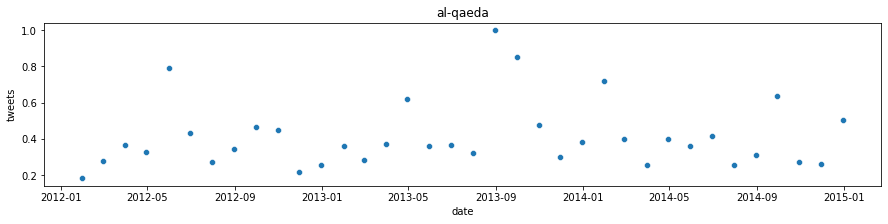

In [26]:
# Here is an example of this operation on a single article :
keyword = 'al-qaeda'
monthly = terrorism_df[terrorism_df.article == keyword].groupby(pd.Grouper(key='date', freq='M')).sum()
monthly['tweets'] = monthly.tweets/monthly.tweets.max() # Here we divide by max tweets in a month
plt.figure(figsize=(15,3))
sns.scatterplot(x='date', y='tweets', data=monthly)
plt.title(keyword)
plt.show()
# As we can see, the only the y-axis changed, but the relative values are the same

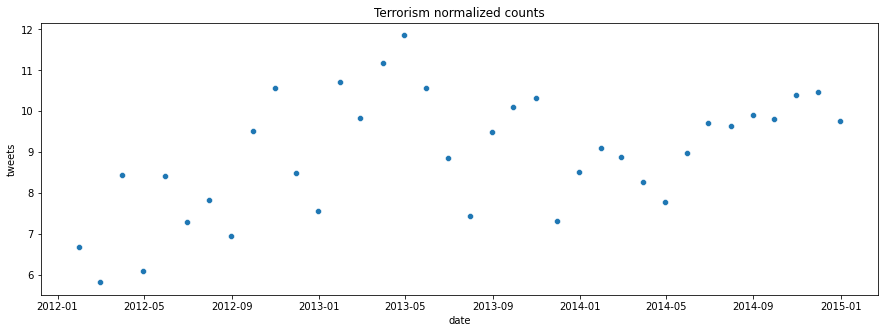

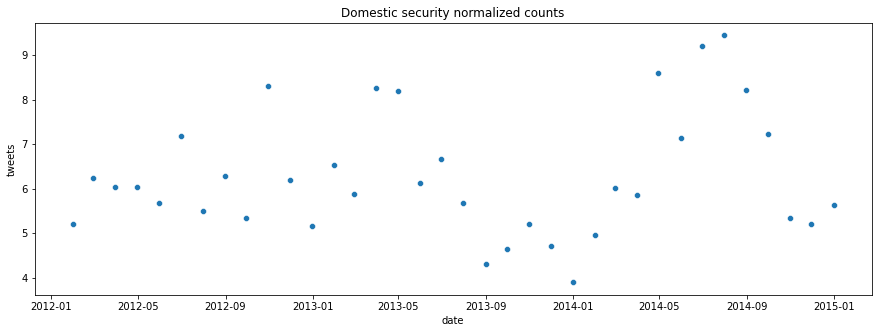

In [29]:
# Now we apply this operation on all keywords before summing
def normalize_df_and_plot_monthly(df, title):
    """Normalize the articles in df by dividing the articles counts by their respective maximum monthly counts."""
    copy = df.copy()
    for keyword in copy.article.unique():
        #Compute the monthly counts
        monthly = copy[copy.article == keyword].groupby(pd.Grouper(key='date', freq='M')).sum()
        #Normalize the current article counts
        copy.tweets = np.where(copy.article == keyword, copy.tweets/monthly.tweets.max(), copy.tweets)
    norm_monthly_df = copy.groupby(pd.Grouper(key='date', freq='M')).sum().reset_index()
    
    #Plot the normalized dataframe
    plt.figure(figsize=(15,5))
    sns.scatterplot(x='date', y='tweets', data=norm_monthly_df)
    plt.title(title)
    return norm_monthly_df

normalized_terrorism_df = normalize_df_and_plot_monthly(terrorism_df, 'Terrorism normalized counts')
normalized_domestic_df = normalize_df_and_plot_monthly(domestic_df, 'Domestic security normalized counts')

However an issue arises now because keywords with very few tweets might be very irregular since stability comes from having a lot of users taking turns tweeting about a subjects. For instance, the trend of a keyword that is only tweeted by 10 people might be severely affected if only one of them stops. We will look at the mean number of tweets per subject and take out articles with under 100 tweets per day on average.

In [64]:
def eliminate_low_tweets(df):
    df_means = df.groupby(pd.Grouper(key='article')).mean()
    nb_keywords = df_means.index.nunique()
    df_means = df_means[df_means.tweets > 100.0]
    new_nb_keywords = df_means.index.nunique()
    print('Eliminated {} keywords out of {}'.format(nb_keywords - new_nb_keywords, nb_keywords))
    return df[df.article.isin(df_means.index)]

filtered_terrorism_df = eliminate_low_tweets(terrorism_df)
filtered_domestic_df = eliminate_low_tweets(domestic_df)

Eliminated 16 keywords out of 27
Eliminated 17 keywords out of 24


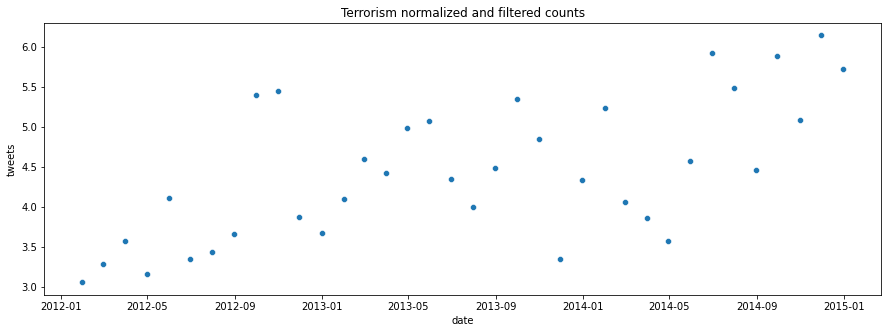

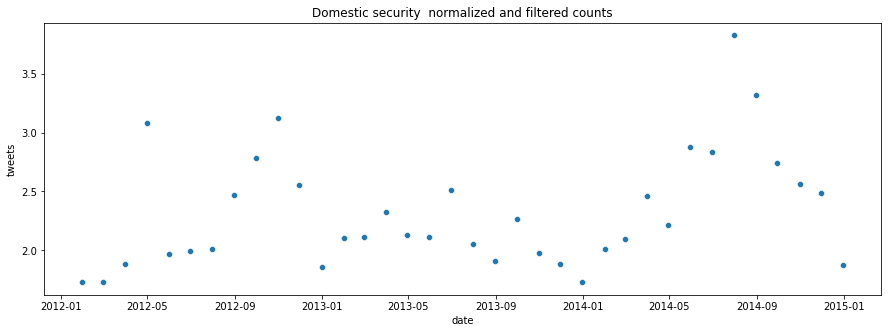

In [65]:
final_terrorism_df = normalize_df_and_plot_monthly(filtered_terrorism_df, 'Terrorism normalized and filtered counts')
final_domestic_df = normalize_df_and_plot_monthly(filtered_domestic_df, 'Domestic security  normalized and filtered counts')

The trends look somewhat smoother now. We can proceed with the analysis

# 4 - Data analysis

In [66]:
# We start by merging both dataframes
total_tweets = final_domestic_df.copy()
total_tweets = total_tweets.rename(columns={"tweets": "tweets_security"})
total_tweets['tweets_terrorism'] = final_terrorism_df['tweets']

# Then we sort by month, and reset the index to have them numbered in increasing order
total_tweets = total_tweets.sort_values('date')
total_tweets.head()

,date,tweets_security,tweets_terrorism
0,2012-01-31,1.727746,3.054700
1,2012-02-29,1.734141,3.290300
2,2012-03-31,1.886777,3.568069
3,2012-04-30,3.081733,3.156634
4,2012-05-31,1.971143,4.112672


Now we perform the Interrupted Time Series analysis

The regression formula is as follows : $$Y_t = \beta_0 + \beta_1\times time + \beta_2\times intervention + \beta_3\times postslope + \epsilon_{1}$$

Where $Y_t$ is the views at time $t$, the $\beta$ are the parameters of the model, and $\epsilon_1$ is the residuals

There are 3 variables that are used to predict the total views :

`time`, `intervention` and `postslope`. I will create a column for each in the dataframe :

- Time: This is just the current month, from 1 to 32
- Intervention: Whether or not the interruption has happened already (0 for the first 17 months, then 1)
- Postslope: The time since the interruption (0 for the first 17 months, then $time - 17$)

In [67]:
# Now we create those variables in our dataframe
total_tweets['time'] = total_tweets.index+1
total_tweets['intervention'] = np.where(total_tweets['time'] <= 17, 0, 1)
total_tweets['postslope'] = (total_tweets.time - 17) * total_tweets.intervention

In [72]:
# Now that all our variables are ready, we can fit our regressions (one for each dataset)
def regression_model(df, name):
    # Declaring the model
    print('\n{} model :'.format(name))
    model = smf.ols(formula='tweets_{} ~ time + intervention + postslope'.format(name), data=df)

    # Fitting the model
    np.random.seed(1)
    result = model.fit()

    # Checking the results
    print(result.summary())
    return result

result_terrorism = regression_model(total_tweets, 'terrorism')
result_security = regression_model(total_tweets, 'security')


terrorism model :
                            OLS Regression Results                            
Dep. Variable:       tweets_terrorism   R-squared:                       0.484
Model:                            OLS   Adj. R-squared:                  0.435
Method:                 Least Squares   F-statistic:                     9.990
Date:                Sun, 13 Dec 2020   Prob (F-statistic):           8.46e-05
Time:                        18:00:13   Log-Likelihood:                -33.905
No. Observations:                  36   AIC:                             75.81
Df Residuals:                      32   BIC:                             82.14
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.1010      

For the first model, the terrorism keywords, we find an adjusted R-squared value of 0.435, which means that even when accounting for the number of parameters, there is quite a strong explanatory power. Indeed, our p-value for `time` is very close to zero, and even though the p-value for `intervention` is higher, is is still under 0.05, which suggests a significance in this result. On the other hand, the p-value of `postslope` is greater than 0.05 which  means that the statistical significance for this parameter is very weak. So overall, the results point to an immediate decrease in tweets after the Snowden revelations (intervention = -0.37) but no significant change in the upwards post-intervention trend.

For the second model, we only have R-squared = 0.164 which is not very high, but when adjusting for the number of parameters, the explanatory power falls to 0.086. Furthermore, all p-values are above 0.2, only suggesting at best a very weak predictive power for both `intervention` and `postslope`. It seems like the model is not very relevant for this set of keywords. This is expected from keywords which were not supposed to be affected by Chilling Effects.

In [73]:
# We now have the parameters of our model, so we can make our predictions for the total tweets per month
# We also produce 95% confidence intervals
def predict(result, df, name):
    beta_0 = result.params['Intercept']
    beta_1 = result.params['time']
    beta_2 = result.params['intervention']
    beta_3 = result.params['postslope']
    confidence = result.get_prediction(total_tweets).conf_int(alpha=0.05)
    df['prediction_{}'.format(name)] = beta_0 + beta_1*df.time + beta_2*df.intervention + beta_3*df.postslope
    df['confidence_lower_{}'.format(name)] = confidence[:, 0]
    df['confidence_upper_{}'.format(name)] = confidence[:, 1]
    
predict(result_terrorism, total_tweets, 'terrorism')
predict(result_security, total_tweets, 'security')
total_tweets.head()

,date,tweets_security,tweets_terrorism,time,intervention,postslope,prediction_terrorism,confidence_lower_terrorism,confidence_upper_terrorism,prediction_security,confidence_lower_security,confidence_upper_security
0,2012-01-31,1.727746,3.054700,1,0,0,3.208570,2.585918,3.831223,2.126097,1.680309,2.571886
1,2012-02-29,1.734141,3.290300,2,0,0,3.316172,2.749064,3.883280,2.139692,1.733671,2.545714
2,2012-03-31,1.886777,3.568069,3,0,0,3.423773,2.909635,3.937912,2.153287,1.785190,2.521385
3,2012-04-30,3.081733,3.156634,4,0,0,3.531375,3.066750,3.996000,2.166882,1.834234,2.499531
4,2012-05-31,1.971143,4.112672,5,0,0,3.638977,3.219184,4.058769,2.180478,1.879927,2.481028


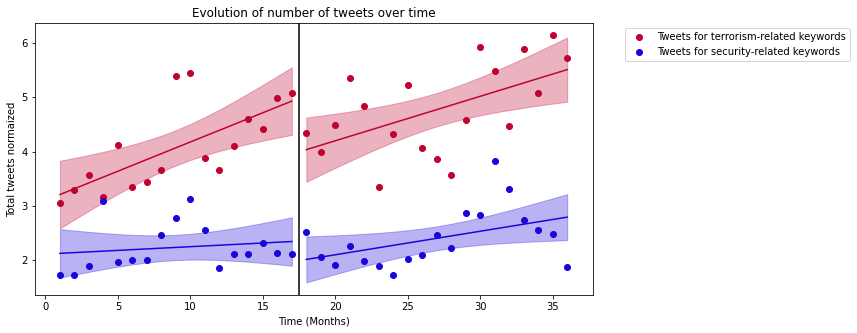

In [78]:
# Finally, we plot the results with 95% confidence intervals
def plot_half(half, df, color, label='__nolegend__'):
    x = half['time']
    plt.plot(x, half['prediction_{}'.format(df)], color=color)
    plt.scatter(x, half['tweets_{}'.format(df)], color=color, label=label)
    plt.fill_between(x, half['confidence_lower_{}'.format(df)], half['confidence_upper_{}'.format(df)], color=color, alpha=0.3)

def plot_predictions(df, name, color):
    total_tweets_pre_interruption = total_tweets[:17]
    total_tweets_post_interruption = total_tweets[17:]
    plot_half(total_tweets_pre_interruption, name, color, label='Tweets for {}-related keywords'.format(name))
    plot_half(total_tweets_post_interruption, name, color)
    
    

plt.figure(figsize=(10,5))
plot_predictions(total_tweets, 'terrorism', 'xkcd:lipstick red')
plot_predictions(total_tweets, 'security', 'xkcd:ultramarine blue')
plt.axvline(17.5, color='black', label='_nolegend_')
plt.xlabel('Time (Months)')
plt.ylabel('Total tweets normaized')
plt.title("Evolution of number of tweets over time")
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In accordance with the model parameters commented above, we observe a drop in tweets following the Snowden revelations, but no change in the trend for the terrorism keywords
For the security keywords, there is almost no drop, and only a very slight change in trend (going up)